In [1]:
#! pip install tensorflow opencv-python


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import AdamW
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)


In [3]:
# Load the dataset
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Reshape the data to fit the model (28x28 grayscale images)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize the data (pixel values between 0 and 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=25)
y_test = to_categorical(y_test, num_classes=25)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


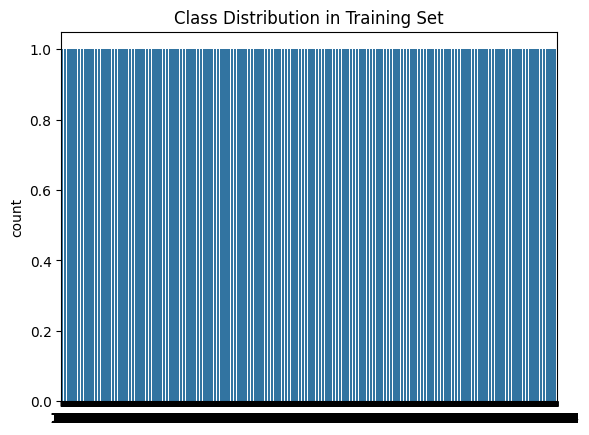

In [4]:
sns.countplot(train_df['label'])
plt.title('Class Distribution in Training Set')
plt.show()

In [5]:
datagen = ImageDataGenerator(
    rotation_range=15,       # Increased rotation range
    zoom_range=0.2,          # Increased zoom range
    width_shift_range=0.2,   # Shift image horizontally
    height_shift_range=0.2,  # Shift image vertically
    shear_range=0.15,        # Shear images
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill mode for transformed pixels
)
datagen.fit(X_train)


In [6]:
model = Sequential()

# Convolutional layers with Dropout and Batch Normalization
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers with higher dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))  # Higher dropout to prevent overfitting
model.add(Dense(25, activation='softmax'))


c:\Users\arnav\OneDrive\Desktop\My_Workspace\MNIST\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Optimizer with weight decay
optimizer = AdamW(learning_rate=0.001, weight_decay=0.02)  # Increased weight decay

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)


Epoch 1/50


c:\Users\arnav\OneDrive\Desktop\My_Workspace\MNIST\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.0740 - loss: 3.6315 - val_accuracy: 0.0342 - val_loss: 4.3787 - learning_rate: 0.0010
Epoch 2/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.1674 - loss: 2.7061 - val_accuracy: 0.4132 - val_loss: 1.8128 - learning_rate: 0.0010
Epoch 3/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.2603 - loss: 2.2980 - val_accuracy: 0.3440 - val_loss: 1.8462 - learning_rate: 0.0010
Epoch 4/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.3523 - loss: 1.9839 - val_accuracy: 0.4966 - val_loss: 1.7710 - learning_rate: 0.0010
Epoch 5/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.4205 - loss: 1.7560 - val_accuracy: 0.5028 - val_loss: 1.4598 - learning_rate: 0.0010
Epoch 6/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.4670 - loss: 1.6044 - val_accuracy: 0.6981 - val_loss: 0.8488 - learning_rate: 0.0010
Epoch 7/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5038 - loss: 1.4757 -

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8604 - loss: 0.4555
Test accuracy: 0.8598717451095581


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


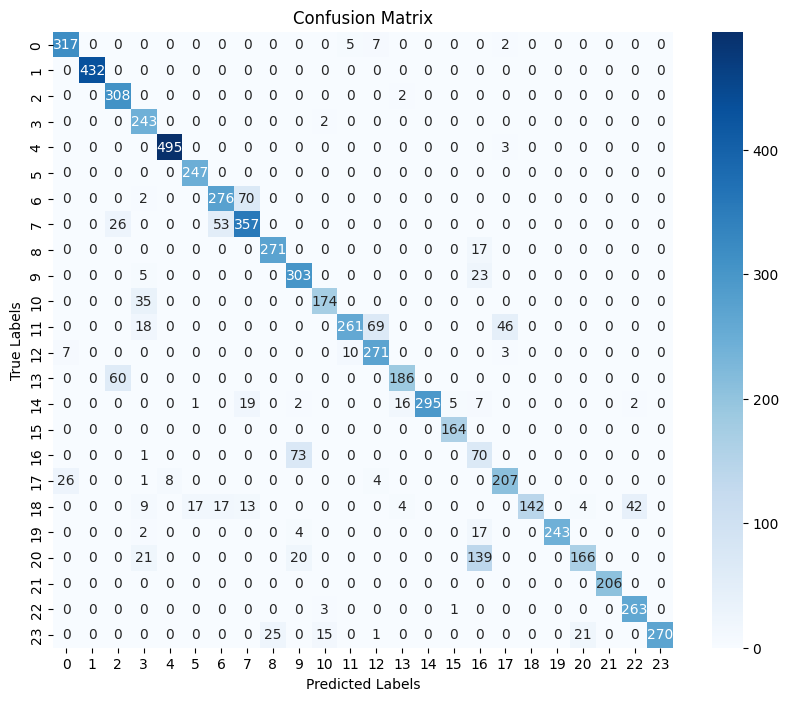

In [11]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


In [12]:
# Load the trained model
model = load_model('best_model.keras')

# Define the labels for the Sign Language MNIST dataset
labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 
          8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 
          15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 
          22: 'W', 23: 'X', 24: 'Y'}

def preprocess_frame(frame):
    # Preprocess the frame to match the input shape required by the CNN model
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_frame = cv2.resize(gray_frame, (28, 28))  # Resize to 28x28 pixels
    normalized_frame = resized_frame / 255.0  # Normalize pixel values between 0 and 1
    reshaped_frame = np.reshape(normalized_frame, (1, 28, 28, 1))  # Reshape to (1, 28, 28, 1)
    
    return reshaped_frame

# Start video capture from the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()  # Capture frame-by-frame
    if not ret:
        break
    
    # Preprocess the captured frame
    processed_frame = preprocess_frame(frame)
    
    # Make prediction using the trained model
    prediction = model.predict(processed_frame)
    predicted_label = np.argmax(prediction)  # Get the index of the highest probability
    predicted_sign = labels[predicted_label]  # Map the index to the corresponding sign language letter
    
    # Display the predicted sign on the frame
    cv2.putText(frame, f'Prediction: {predicted_sign}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Show the frame with prediction
    cv2.imshow('Hand Gesture Recognition', frame)
    
    # Exit the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━